In [1]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.layers import Conv2D, Conv2DTranspose, Input, Activation, MaxPooling2D, Add, BatchNormalization, Reshape
from keras.models import Model
from keras.initializers import TruncatedNormal
from keras import regularizers
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from glob import glob
import random
import os
import re
import cv2
from scipy.misc import imread, imresize
from sklearn.utils import shuffle
%matplotlib inline

Using TensorFlow backend.


The first step is to download the pretrained VGG16 network which the FCN will be build on top of.

By setting `include_top` to `False` we are able to specify the desired input shape for the model.

In [0]:
input_shape = (160,480,3)
vgg = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

Next I will extract the necessary layers from the VGG16 model and apply techniques of upsampling, 1x1 convolutions and skip connections to build the FCN.

The FCN16 arhitecture uses a single skip layer which combines the block 4 pooling layer with the second fully connected layer. 

The output layer is a transpose convolution with `strides = 16`.

In [0]:
def get_FCN16(num_classes):
    # Define a custom initializer
    custom_init = TruncatedNormal(stddev=0.01)

    # Get the block 4 pooling layer from VGG
    pool4 = vgg.get_layer('block4_pool').output

    # Get the block 5 pooling layer from VGG
    pool5 = vgg.get_layer('block5_pool').output

    # Create a convolutionalized version of the first fully connected layer
    fc6 = Conv2D(4096, (7,7), kernel_initializer = custom_init,
               kernel_regularizer = regularizers.l2(0.01), padding='Same')(pool5)

    # Create a convolutionalized version of the second fully connected layer
    fc7 = Conv2D(4096, (1,1), kernel_initializer = custom_init,
               kernel_regularizer = regularizers.l2(0.01), padding='Same')(fc6)

    # Upsample and combine fc7 with pool 4
    layer_7_1x1 = (Conv2D(num_classes, (1,1), kernel_initializer = custom_init,
                 kernel_regularizer = regularizers.l2(0.01), padding='Same'))(fc7)

    upsample1 = (Conv2DTranspose(num_classes, (4,4), strides = 2, kernel_initializer = custom_init,
               kernel_regularizer = regularizers.l2(0.01), padding='Same'))(layer_7_1x1)
    x = (BatchNormalization(axis=1))(upsample1)
    layer_4_1x1 = (Conv2D(num_classes, (1,1), kernel_initializer = custom_init,
                        kernel_regularizer = regularizers.l2(0.01), padding='Same'))(pool4)
    x = Add()([x, layer_4_1x1])

    # Upsample to input image shape
    upsample2 = (Conv2DTranspose(num_classes, (32,32), strides = 16, kernel_initializer = custom_init,
                               kernel_regularizer = regularizers.l2(0.01), padding='Same'))(x)

    out_layer = (Activation('softmax'))(upsample2)

    model = Model(vgg.get_layer('input_1').output, out_layer)


    return model

In [4]:
# Build the model with num_classes set to 2 
fcn16 = get_FCN16(2)
fcn16.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 160, 480, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 160, 480, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 160, 480, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 80, 240, 64)  0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

In [0]:
# Compile the Model
adam = Adam(lr = 0.001)
fcn16.compile(optimizer=adam,
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

Next I am going to implement a python generator to load batches of images and avoid having to store all of the images in menory at once. I am also going to split the images into training and validations sets with 20% of the images used for validation.

In [0]:
data_folder = 'data_road/training'

image_paths = glob(os.path.join(data_folder, 'image_2', '*.png'))
image_paths = shuffle(image_paths)
label_paths = {re.sub(r'_(lane|road)_', '_', os.path.basename(path)): path
    for path in glob(os.path.join(data_folder, 'gt_image_2', '*_road_*.png'))}

num_samples = len(image_paths)
num_training = int(num_samples*0.8)
training_images = image_paths[:num_training]
val_images = image_paths[num_training:]

def generator(image_paths, image_shape, batch_size, training = True):
    background_color = np.array([255, 0, 0])
    while 1:
        random.shuffle(image_paths)
        for batch_i in range(0, len(image_paths), batch_size):
            images = []
            gt_images = []
            for image_file in image_paths[batch_i:batch_i+batch_size]:
                gt_image_file = label_paths[os.path.basename(image_file)]

                image = imresize(imread(image_file), image_shape)
                gt_image = imresize(imread(gt_image_file), image_shape)

                gt_bg = np.all(gt_image == background_color, axis=2)
                gt_bg = np.expand_dims(gt_bg, axis=2)
                gt_image = np.concatenate((gt_bg, np.invert(gt_bg)), axis=2)

                images.append(image)
                gt_images.append(gt_image)

            yield np.array(images), np.array(gt_images)

In [18]:
checkpoint = ModelCheckpoint('fcn16_weights.h5', monitor='val_loss', save_best_only=True, save_weights_only=True)

batch_size=8
train_generator = generator(training_images, (160,480), batch_size=batch_size)
val_generator = generator(val_images, (160,480), batch_size=batch_size)
fcn8_history = fcn8.fit_generator(train_generator, steps_per_epoch = num_training//batch_size,
                    epochs = 25, verbose = 1, validation_data = val_generator,
                    validation_steps = (num_samples - num_training)//batch_size, callbacks=[checkpoint])

Epoch 15/25


/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


28/28 [==============================] - 39s 1s/step - loss: 0.0739 - acc: 0.9721 - val_loss: 0.1195 - val_acc: 0.9554
Epoch 16/25
28/28 [==============================] - 38s 1s/step - loss: 0.0723 - acc: 0.9722 - val_loss: 0.1017 - val_acc: 0.9659
Epoch 17/25
28/28 [==============================] - 38s 1s/step - loss: 0.0650 - acc: 0.9753 - val_loss: 0.1002 - val_acc: 0.9671
Epoch 18/25
28/28 [==============================] - 38s 1s/step - loss: 0.0604 - acc: 0.9776 - val_loss: 0.1112 - val_acc: 0.9624
Epoch 19/25
28/28 [==============================] - 38s 1s/step - loss: 0.0586 - acc: 0.9774 - val_loss: 0.1322 - val_acc: 0.9626
Epoch 20/25
28/28 [==============================] - 38s 1s/step - loss: 0.0509 - acc: 0.9800 - val_loss: 0.1110 - val_acc: 0.9648
Epoch 21/25
28/28 [==============================] - 38s 1s/step - loss: 0.0567 - acc: 0.9780 - val_loss: 0.1025 - val_acc: 0.9674
Epoch 22/25
 3/28 [==>...........................] - ETA: 31s - loss: 0.0474 - acc: 0.981328/28

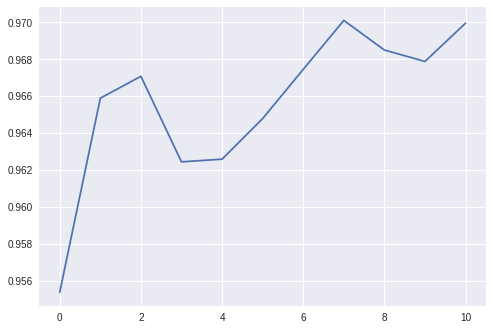

In [30]:
plt.plot(fcn16_history.history['val_acc'])
plt.show()

In [0]:
fcn16.load_weights('fcn16_weights.h5')

#### Visualize the predictions on some test images.

Next I am going to load a couple of test images and visualize the predictions overlaid back on to the images. This will allow us to evaluate how well the model was able to identify the boundaries of the road.

/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


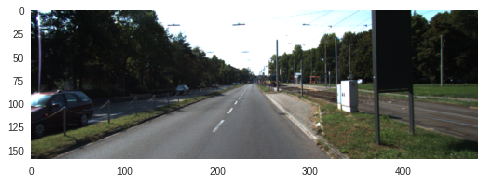

In [32]:
test_image = imresize(imread('data_road/testing/image_2/um_000000.png'), (160,480))
plt.grid('off')
plt.imshow(test_image);

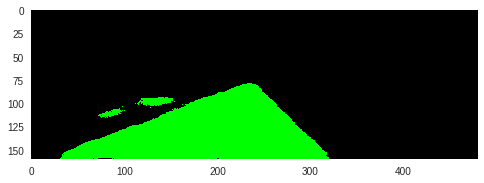

In [34]:
pred = fcn16.predict(test_image.reshape(1,160,480,3))
mask = np.dstack((np.zeros_like(pred[0,:,:,0]),
                 np.round(pred[0,:,:,1]),
                 np.zeros_like(pred[0,:,:,0])))
plt.grid('off')
plt.imshow(mask.astype('uint8')*255);

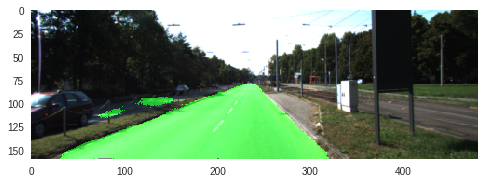

In [36]:
output = cv2.addWeighted(test_image, 1.0, mask.astype('uint8')*255, 0.6, 0)
plt.grid('off')
plt.imshow(output);

/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


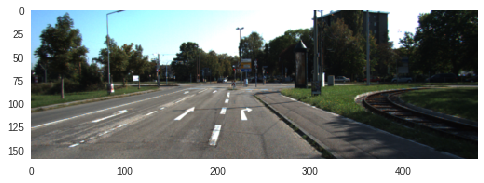

In [37]:
test_image = imresize(imread('data_road/testing/image_2/umm_000002.png'), (160,480))
plt.grid('off')
plt.imshow(test_image);

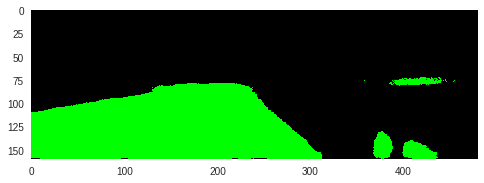

In [38]:
pred = fcn16.predict(test_image.reshape(1,160,480,3))
mask = np.dstack((np.zeros_like(pred[0,:,:,0]),
                 np.round(pred[0,:,:,1]),
                 np.zeros_like(pred[0,:,:,0])))
plt.grid('off')
plt.imshow(mask.astype('uint8')*255);

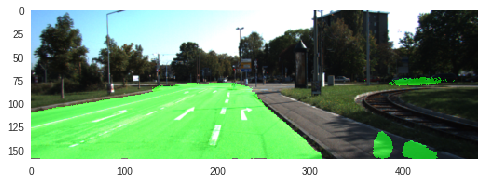

In [40]:
output = cv2.addWeighted(test_image, 1.0, mask.astype('uint8')*255, 0.6, 0)
plt.grid('off')
plt.imshow(output);

The predictions from this model are a significant improvement over the FCN32. The road boundaries appear to be much more clearly defined.